
# Tennis PDI - Match Length Prediction Using A Regression Forest

In [ ]:
# This is the notebook used in Leo's project to showcase the whole pipeline using the model yielding best R2-scores.

# How to use this notebook:

Important: In order to store data or models, don't forget to set appropriate booleans like register_dataframe to True.

Code to update the database :

    -> "Updating the database"
    -> "Code to run in order to update additional features's database"


Code to update the model:

    -> "Code to train the best model on the data including additional features"

In order to upload the new model on the github, use basic git commands:
    
    ->  (if not already cloned on your local computer: git clone https://github.com/leobeuque/PDI-Tennis.git )
    -> git add file_name
    -> git commit -m "message”
    -> git push origin main

In [15]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install sklearn

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import ipywidgets as widgets
#from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

from functools import partial
from datetime import date
from datetime import timedelta
import dateutil.parser


import joblib
import os

In [2]:
# Necessary functions related to match's dates
def get_day_diff(iso_date_cur, iso_date_ref='20220801'):
    """Gets differences between two dates.
    Args:
        iso_date_cur (str): date of the current match's tournament.
        iso_date_ref (str, optional): Defaults to '20220801'.
    """
    datetime_cur = dateutil.parser.isoparse(str(iso_date_cur))
    datetime_ref = dateutil.parser.isoparse(iso_date_ref)
    days_diff = (datetime_ref - datetime_cur).days
    return days_diff

def get_recency_weight(iso_date_cur, Lambda = 365):
    """ returns a weight that gives less importance to old data
    Args: 
        Lambda (int, optional): half-life of the decay. Defaults to 365.
    """
    days_diff = get_day_diff(iso_date_cur)
    recency_weight = (1/2)**(days_diff/Lambda)
    return recency_weight
def get_train_weights(Xtrain, Lambda=1500):
    """Process recency_weights for Xtrain data
    """
    train_weights = list(Xtrain['tourney_date'].map(partial(get_recency_weight, Lambda=Lambda)))
    train_weights = np.array(train_weights)
    return train_weights

def get_former_year_date(iso_date):
    #iso_date is in the following form: 20120825
    former_year = int(str(iso_date)[:4]) - 1
    former_year_date = int(str(former_year) + str(iso_date)[4:])
    return former_year_date

def get_n_former_years_date(iso_date, n_years):
    #iso_date is in the following form: 20120825
    n_former_year = int(str(iso_date)[:4]) - n_years
    n_former_year_date = int(str(n_former_year) + str(iso_date)[4:])
    return n_former_year_date

def get_former_day_date(iso_date):
    #iso_date is in the following form: 20120825
    datetime_cur = dateutil.parser.isoparse(str(iso_date))
    former_day_date_iso = str(datetime_cur - timedelta(days=1))
    former_day_date = former_day_date_iso[:4] + former_day_date_iso[5:7] + former_day_date_iso[8:10]
    return int(former_day_date)

# Updating the database

In [ ]:

def update_atp_cat():
    """Uses Jeff Sackmann's github repository to update atp_cat and store it.
    """
    path_to_ATP_matches = "D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches"

    # Deleting the former folder containing data for all atp matches

    try:
        shutil.rmtree(path_to_ATP_matches)
    except OSError:
        print ("Deletion of the directory %s failed" % path_to_ATP_matches)
    else:
        print ("Successfully deleted the directory %s" % path_to_ATP_matches)
    # Creating an empty folder
    try:
        os.mkdir(path_to_ATP_matches)
    except OSError:
        print ("Creation of the directory %s failed" % path_to_ATP_matches)
    else:
        print ("Successfully created the directory %s " % path_to_ATP_matches)
        
        
    # Cloning the Sackmann's whole repository before deleting unnecessary files
    # "Git does not directly support cloning only a specific file or directory from a repository."
    # todo : Check if this is really impossible or not, in order to avoid downloading unnecessary files

    github_url = "https://github.com/JeffSackmann/tennis_atp"
    git.Repo.clone_from(github_url, path_to_ATP_matches)


    # Getting rid of unnecessary files
    def is_standard_atp_file(filename):
        if len(filename) == len("atp_matches_xxxx.csv"):
            first_part = filename[:len("atp_matches_")] == "atp_matches_"
            last_part = filename[-len(".csv"):] == ".csv"
            is_standard_atp_file_bool = first_part and last_part
            return is_standard_atp_file_bool
        else:
            return False
    # todo : problem with the .git file to fix
    # todo : problem with folders to fix 
    path_to_ATP_matches = "D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches"
    for file_name in listdir(path_to_ATP_matches):
        if not is_standard_atp_file(file_name):   
            try:
                os.remove(path_to_ATP_matches + "/" + file_name)
            except OSError:
                print ("Deletion of the file %s failed" % file_name)
            else:
                print ("Successfully deleted the file %s" % file_name)
            #shutil.rmtree(path_to_ATP_matches + "/" + file_name)
            
    # Concatenation of atp csv files in one file
    # todo: check if the paths are correctly handled in the scenario of a remote python virtual environnement
    atp = pd.concat(map(pd.read_csv, glob.glob('ATP_matches/atp_matches_????.csv')))
    atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
    atp = atp.dropna(subset=['minutes', 'surface'])
    atp = atp.drop(labels=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", # Data strongly correlated to the target
                            "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced"], axis=1)
    
    if atp.shape[0] >0: # Then, atp_cat.csv is updated
        try:
            os.remove("atp_cat.csv")
        except OSError:
            print ("Removal of atp_cat.csv failed")
        else:
            atp = atp[atp['tourney_date'] >= 19901231]
            atp.to_csv("atp_cat.csv")
            print ("Successfully updated atp_cat.csv")

perform_update_atp_cat = False #todo : à passer à True
if perform_update_atp_cat:
    update_atp_cat()
    

Successfully deleted the directory D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches
Successfully created the directory D:/Cours_Centrale/Centrale_G3/projet_rattrapage/PDI_modele_predictif/code_folder/PDI-Tennis/ATP_matches 
Deletion of the file .git failed
Successfully deleted the file .gitattributes
Successfully deleted the file atp_matches_amateur.csv
Successfully deleted the file atp_matches_doubles_2000.csv
Successfully deleted the file atp_matches_doubles_2001.csv
Successfully deleted the file atp_matches_doubles_2002.csv
Successfully deleted the file atp_matches_doubles_2003.csv
Successfully deleted the file atp_matches_doubles_2004.csv
Successfully deleted the file atp_matches_doubles_2005.csv
Successfully deleted the file atp_matches_doubles_2006.csv
Successfully deleted the file atp_matches_doubles_2007.csv
Successfully deleted the file atp_matches_doubles_2008.csv
Successfully deleted the file atp_matches_doubles_2009.csv

# Different Preprocessing functions

In [3]:
# Function to use when additional features are used
def preprocessing(player_table, scale_x=False, scale_y=False) :
    target='minutes'

    # 1. X, y unscaled
    X = player_table.drop([target], axis=1)
    y = np.asarray(player_table[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        columns_to_scale = ['player_ht', 'opp_ht', 'player_age', 'opp_age',
       'player_rank', 'opp_rank', 'player_rank_points', 'opp_rank_points',
       'rank_diff', 'rank_points_diff', 'diff_aces_frequency', 'diff_double_fault_frequency',
        'diff_serve_won_frequency', 'diff_points_won_frequency','diff_completeness', 'diff_advantage_on_serve']
        # todo : to update
        xscaler.fit(X[columns_to_scale])
        X[columns_to_scale] = xscaler.transform(X[columns_to_scale])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    #display(pd.DataFrame(X).head())
    #display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

def preprocess_atp(atp, is_atp_raw=False, train_df_columns=[], scale_x=False):
    """On considère ici que la table atp contient déjà les informations sur le gagnant contre le perdant:
    final_additional_features = final_additional_features_winner - final_additional_features_loser
    """
    
    # if is_atp_raw:
    #     atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
    #     atp = atp.dropna(subset=['minutes', 'surface'])
    #     atp = atp.drop(labels=["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", # Data strongly correlated to the target
    #                         "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced"], axis=1)
    
    preprocessed_atp = atp.copy()

    is_train_set = len(train_df_columns) == 0
    
    # if is_train_set:
    #     # Removing potential outliers from the training set    
    #     list_unusual_score_words = ["w/o", "ret", "def"]
    #     for unusual_word in list_unusual_score_words:
    #         preprocessed_atp = preprocessed_atp.reset_index(drop=True)
    #         bool_array = [unusual_word in str(score).lower() for score in preprocessed_atp["score"]]
    #         preprocessed_atp = preprocessed_atp.drop(preprocessed_atp[bool_array].index)

    #     preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes > 35]
    #     preprocessed_atp = preprocessed_atp[preprocessed_atp.minutes < 665]
    
    
    allow_losing_player_information = False # todo : vérifier si le "True" peut être utile ou non. Si non, le supprimer.
    
    features_to_keep = ["minutes", "tourney_date", "surface", "best_of", "winner_hand", "loser_hand", "winner_ht",
                        "loser_ht", "winner_age", "loser_age", "tourney_level", "round", "winner_rank", "loser_rank",
                        "winner_rank_points", "loser_rank_points",'diff_aces_frequency', 'diff_double_fault_frequency',
                        'diff_serve_won_frequency', 'diff_points_won_frequency','diff_completeness', 'diff_advantage_on_serve']
    preprocessed_atp = pd.DataFrame(preprocessed_atp[features_to_keep])
    
    # player1_pf.loc[:,"consecutive"] = atp.loc[:,"consecutive"] #todo: implement win streak
    mirrored_atp = preprocessed_atp.copy() # Only used if allow_losing_player_information is False
    preprocessed_atp = preprocessed_atp.rename(columns={"winner_age": "player_age", "winner_ht": "player_ht", "winner_hand": "player_hand", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})

    if not allow_losing_player_information:
        mirrored_atp = mirrored_atp.rename(columns={"loser_age": "player_age", "loser_ht": "player_ht", "loser_hand": "player_hand", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                            "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_age":"opp_age",
                                            "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
        get_opposite_features = ['diff_aces_frequency', 'diff_double_fault_frequency',
                                 'diff_serve_won_frequency', 'diff_points_won_frequency',
                                 'diff_completeness', 'diff_advantage_on_serve']
        mirrored_atp[get_opposite_features] = -mirrored_atp[get_opposite_features]
        
        preprocessed_atp = pd.concat([preprocessed_atp, mirrored_atp])
        # player.drop(list(player.filter(regex = 'Unnamed')), axis = 1, inplace = True)
        
    preprocessed_atp.sort_index(inplace=True)
    # Creating new features
    
    preprocessed_atp["rank_diff"] = preprocessed_atp.loc[:,"player_rank"] - preprocessed_atp.loc[:,"opp_rank"]
    preprocessed_atp["rank_points_diff"] = preprocessed_atp.loc[:,"player_rank_points"] - preprocessed_atp.loc[:,"opp_rank_points"]
    #preprocessed_atp["age_diff"] = preprocessed_atp.loc[:,"player_age"] - preprocessed_atp.loc[:,"opp_age"]
    #preprocessed_atp["ht_diff"] = preprocessed_atp.loc[:,"player_ht"] - preprocessed_atp.loc[:,"opp_ht"]
    
    # Same thing but in order to absolutely avoid using the player/opponent order
    if allow_losing_player_information:
        keep_optimums = True
        if keep_optimums:
            #todo : to be computed
            preprocessed_atp["rank_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            preprocessed_atp["rank_points_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            preprocessed_atp["age_max"] = np.maximum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            preprocessed_atp["ht_min"] = np.minimum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            # preprocessed_atp["rank_min"] = np.minimum(preprocessed_atp.loc[:,"player_rank"], preprocessed_atp.loc[:,"opp_rank"])
            # preprocessed_atp["rank_points_max"] = np.maximum(preprocessed_atp.loc[:,"player_rank_points"], preprocessed_atp.loc[:,"opp_rank_points"])
            # preprocessed_atp["age_min"] = np.minimum(preprocessed_atp.loc[:,"player_age"], preprocessed_atp.loc[:,"opp_age"])
            # preprocessed_atp["ht_max"] = np.maximum(preprocessed_atp.loc[:,"player_ht"], preprocessed_atp.loc[:,"opp_ht"])
            
        calculate_handers = False
        if calculate_handers: #implementing 3 categories for players' hands : (("R"/"L", "L"/"R", "U"/"R" or "L", "R" or "L"/"U"), ("R"/"R"), ("L"/"L"))
            # todo: check if this works
            preprocessed_atp["left_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "L", preprocessed_atp["left_handers"] == "L")
            preprocessed_atp["right_handers"] = np.logical_and(preprocessed_atp["left_handers"] == "R", preprocessed_atp["left_handers"] == "R")
            preprocessed_atp["diff_handers"] = np.logical_not(np.logical_or(preprocessed_atp["left_handers"], preprocessed_atp["right_handers"]))   
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        else:
            preprocessed_atp = preprocessed_atp.drop(["player_hand", "opp_hand", 'player_ht', 'opp_ht', 'player_age', 'opp_age', 'opp_rank_points','opp_rank','player_rank', 'player_rank_points'], axis=1)
            preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "tourney_level", "round"])
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        # todo : remove hands
        
    else:
        # One-Hot Encoding
        #preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "winner_hand", "loser_hand", "tourney_level", "round"])
        preprocessed_atp = pd.get_dummies(preprocessed_atp, columns=["surface", "best_of", "player_hand", "opp_hand", "tourney_level", "round"])
    
    preprocessed_atp = preprocessed_atp.dropna(axis=0, how='any')
    preprocessed_atp = preprocessed_atp.drop(['best_of_5','tourney_level_G'], axis=1) #tourney_level_G is too highly correlated to "best_of"
    
    if not is_train_set:
        preprocessed_atp = pd.DataFrame(preprocessed_atp, columns=train_df_columns)
        preprocessed_atp = preprocessed_atp.fillna(0)
        # todo : fillna: point à surveiller!! 
    
    scale_y = False  

    X, y, xscaler, yscaler = preprocessing(preprocessed_atp, scale_x, scale_y)
     
    return X, y

# Code to run in order to update additional features's database

In [2]:
# Getting matches data without deleting features related to the proceeding of the match.

import glob
atp = pd.concat(map(pd.read_csv, glob.glob('ATP_matches/*.csv')))
atp = atp.drop(['tourney_id', 'draw_size', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'loser_id', 'loser_seed', 'loser_entry'], axis=1)
atp = atp.dropna()
#atp = atp[atp['tourney_date'] >= 19901231]
atp = atp[atp['tourney_date'] >= 20050101]
#atp = atp[atp['tourney_date'] >= 20181231]

# Warning: preprocessing data here will affect the test set and eventually yield over-optimistic results.
list_unusual_score_words = ["w/o", "ret", "def"]
for unusual_word in list_unusual_score_words:
    atp = atp.reset_index(drop=True)
    bool_array = [unusual_word in str(score).lower() for score in atp["score"]]
    atp = atp.drop(atp[bool_array].index)

atp = atp[atp.minutes > 35]
atp = atp[atp.minutes < 665]
atp = atp.reset_index(drop=True)
#atp.to_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
atp.to_csv("atp_cat_for_hist_features_calculation_lambda_730_2005.csv")


In [3]:
atp = pd.read_csv("atp_cat.csv")


In [4]:
atp.columns

Index(['Unnamed: 0', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

In [3]:
def get_wmeans_against_opp(common_opp, player_atp, weights_list_max):
    """Computes weighted averages for matches of player_atp against common_opp.
    Also computes associated uncertainties.
    Args:
        common_opp (str): name of the common opponent
        player_atp (Dataframe): table of atp matches of the current player
        weights_list_max (_type_): reference recency_weight from the match of player1 against player2

    Returns:
        df_wmeans_against_opp(dict): 1-row resulting averages.
    """
    player1_atp_opp = player_atp[player_atp["opp_name"] == common_opp] # df of atp matches of the current player against the common opponent
    player1_atp_opp = player1_atp_opp.drop(columns=['player_name', 'opp_name','tourney_date'])
    recency_weights_against_opp = player1_atp_opp["recency_weights"].values/weights_list_max # Selection of the weights of the current table
    # These weights are divided by the weight of the current match in order to update them
    wmeans_hist_data_against_opp = np.average(a = player1_atp_opp, weights=recency_weights_against_opp, axis = 0) # Performing a weighted average of the historical data against the common opponent
    df_wmeans_against_opp = dict(zip(player1_atp_opp.columns, wmeans_hist_data_against_opp))
    df_wmeans_against_opp["nb_matches"] = player1_atp_opp.shape[0]
    df_wmeans_against_opp["weights_sum"] = sum(recency_weights_against_opp) # Calculating actual weighted sum, that will be used for uncertainty
    
    return df_wmeans_against_opp


In [4]:
# template for functions:

def get_features(df_wmeans):
    """ Uses df_player to process new features
    Frequencies are calculated per total number of related points rather than per game, contrary to what has been done by Sipko.
    Args:
        df_wmeans(Dataframe): df_wmeans against opp
    Returns:
        df_wmeans(Dataframe): Dataframe with every features calculated for all current player/opponent pairs.
        These features represent the player's performance against the opponent "opp", using historical matches' data.
    """
    # todo : convertir le dataframe en dictionnaire pour faciliter l'accès aux fonctions..
    # todo : le faire plus haut vu qu'on n'a pas vraiment besoin de dataframe d'une seule ligne
    
    
    df_wmeans["player_aces_frequency"] = 0
    df_wmeans["player_double_fault_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0 
    df_wmeans["player_aces_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_ace"] / df_wmeans[is_div_ok]["player_svpt"]
    df_wmeans["player_double_fault_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_df"] / df_wmeans[is_div_ok]["player_svpt"]   # This feature does not seem necessary but why not
    
    
    df_wmeans["player_first_serve_made_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0
    df_wmeans["player_first_serve_made_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_1stIn"]/df_wmeans[is_div_ok]["player_svpt"]
    
    
    df_wmeans["player_first_serve_won_frequency"] = 0
    is_div_ok = df_wmeans["player_1stIn"] != 0
    df_wmeans["player_first_serve_won_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_1stWon"]/df_wmeans[is_div_ok]["player_1stIn"]
    
    
    df_wmeans["player_second_serve_won_frequency"] = 0 
    is_div_ok = (df_wmeans["player_svpt"] - df_wmeans["player_1stIn"]) != 0 
    df_wmeans["player_second_serve_won_frequency"][is_div_ok] = df_wmeans[is_div_ok]["player_2ndWon"] / (df_wmeans[is_div_ok]["player_svpt"] - df_wmeans[is_div_ok]["player_1stIn"])
    
    
    df_wmeans["player_serve_won_frequency"]= df_wmeans["player_first_serve_won_frequency"] * df_wmeans["player_first_serve_made_frequency"] + df_wmeans["player_second_serve_won_frequency"] * (1 - df_wmeans["player_first_serve_made_frequency"])
    
    
    df_wmeans["player_point_return_won_frequency"] = 0
    is_div_ok = df_wmeans["opp_svpt"] != 0
    df_wmeans["player_point_return_won_frequency"][is_div_ok] = (df_wmeans[is_div_ok]["opp_svpt"] - df_wmeans[is_div_ok]["opp_1stWon"] - df_wmeans[is_div_ok]["opp_2ndWon"])/df_wmeans[is_div_ok]["opp_svpt"]
    
    
    df_wmeans["opp_point_return_won_frequency"] = 0
    is_div_ok = df_wmeans["player_svpt"] != 0
    df_wmeans["opp_point_return_won_frequency"][is_div_ok] = (df_wmeans[is_div_ok]["player_svpt"] - df_wmeans[is_div_ok]["player_1stWon"] - df_wmeans[is_div_ok]["player_2ndWon"])/df_wmeans[is_div_ok]["player_svpt"]
    
    
    df_wmeans["player_points_won_frequency"] = 0
    is_div_ok = (df_wmeans["player_svpt"] + df_wmeans["opp_svpt"]) != 0
    df_wmeans["player_points_won_frequency"][is_div_ok] = (((df_wmeans[is_div_ok]["player_1stWon"] + df_wmeans[is_div_ok]["player_2ndWon"]) + (df_wmeans[is_div_ok]["opp_svpt"] - df_wmeans[is_div_ok]["opp_1stWon"] - df_wmeans[is_div_ok]["opp_2ndWon"])) / (df_wmeans[is_div_ok]["player_svpt"] + df_wmeans[is_div_ok]["opp_svpt"]))
    
    df_wmeans["player_completeness"] = df_wmeans["player_serve_won_frequency"] * df_wmeans["player_point_return_won_frequency"]
    df_wmeans["player_advantage_on_serve"] = df_wmeans["player_serve_won_frequency"] - df_wmeans["opp_point_return_won_frequency"] # Most important feature according to Sipko

    return df_wmeans


In [22]:

# Processing Additional Features using the Common Opponents paradigm

register_dataframe = False # todo : à passer à True
if register_dataframe:
    import xlsxwriter as xls
    workbook = xls.Workbook('hist_features_lambda_730_2005_2.xlsx')
    worksheet = workbook.add_worksheet()
    
hide_SettingWithCopyWarning = True
if hide_SettingWithCopyWarning:
    pd.options.mode.chained_assignment = None

# On crée de bons indices pour cette table nettoyée (atp)
atp = atp.reset_index(drop=True)
# recency_weights_atp = get_train_weights(atp, Lambda=250)
recency_weights_atp = get_train_weights(atp, Lambda=730)
atp["recency_weights"] = recency_weights_atp
#atp = atp.head(1000).reset_index(drop=True)

# On crée une table avec les matchs en doublons, dont on se servira de la façon suivante:
# Joueur étudié en joueur1 et common opponent en joueur 2

preprocessed_atp = atp.copy() # preprocessed atp correspond à la table utilisant les doublons
preprocessed_atp = preprocessed_atp[["winner_name","loser_name", "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon","w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon","l_SvGms", "l_bpSaved", "l_bpFaced", "tourney_date"]
]
mirrored_atp = preprocessed_atp.copy() # La table destinée à inverser l'ordre des joueurs

preprocessed_atp = preprocessed_atp.rename(columns={"winner_name":"player_name", "loser_name":"opp_name"})
preprocessed_atp = preprocessed_atp.rename(columns={"w_ace":"player_ace", "w_df":"player_df", "w_svpt":"player_svpt", "w_1stIn":"player_1stIn", "w_1stWon":"player_1stWon", "w_2ndWon":"player_2ndWon","w_SvGms":"player_SvGms", "w_bpSaved":"player_bpSaved", "w_bpFaced":"player_bpFaced"})
preprocessed_atp = preprocessed_atp.rename(columns={"l_ace":"opp_ace", "l_df":"opp_df", "l_svpt":"opp_svpt", "l_1stIn":"opp_1stIn", "l_1stWon":"opp_1stWon", "l_2ndWon":"opp_2ndWon","l_SvGms":"opp_SvGms", "l_bpSaved":"opp_bpSaved", "l_bpFaced":"opp_bpFaced"})
mirrored_atp = mirrored_atp.rename(columns={"loser_name":"player_name", "winner_name":"opp_name"})
mirrored_atp = mirrored_atp.rename(columns={"l_ace":"player_ace", "l_df":"player_df", "l_svpt":"player_svpt", "l_1stIn":"player_1stIn", "l_1stWon":"player_1stWon", "l_2ndWon":"player_2ndWon","l_SvGms":"player_SvGms", "l_bpSaved":"player_bpSaved", "l_bpFaced":"player_bpFaced"})
mirrored_atp = mirrored_atp.rename(columns={"w_ace":"opp_ace", "w_df":"opp_df", "w_svpt":"opp_svpt", "w_1stIn":"opp_1stIn", "w_1stWon":"opp_1stWon", "w_2ndWon":"opp_2ndWon","w_SvGms":"opp_SvGms", "w_bpSaved":"opp_bpSaved", "w_bpFaced":"opp_bpFaced"})

preprocessed_atp = pd.concat([preprocessed_atp, mirrored_atp])
preprocessed_atp.sort_index(inplace=True)

recency_weights = get_train_weights(preprocessed_atp, Lambda=730)
# recency_weights = get_train_weights(preprocessed_atp, Lambda=250)
preprocessed_atp["recency_weights"] = recency_weights


# Pour chaque match (un couple de joueurs), on récupère la liste des common opponents 
players_list = preprocessed_atp["player_name"].unique()
row_idx = 0 # Used to write data to an excel file
for match_idx, match in atp.iterrows():
    if match_idx%1000 == 0:
        print(f"match_idx: {match_idx}")
    try:
        
        player1_name = match["winner_name"]
        player2_name = match["loser_name"]
        tourney_date = match["tourney_date"]
        min_hist_date = get_n_former_years_date(tourney_date, 8) # Not taking into account matches played more than 8 years 
        # before the current match in order to reduce calculation costs.
        weight_current_match = match["recency_weights"]

        # Getting one table per player
        player1_atp = preprocessed_atp[preprocessed_atp["player_name"] == player1_name]
        # todo : implement this filter in a cleaner way not to eliminate matches coming from the same day
        player1_atp = player1_atp[player1_atp["tourney_date"] < tourney_date]
        player1_atp = player1_atp[player1_atp["tourney_date"] >= min_hist_date]
        
        player2_atp = preprocessed_atp[preprocessed_atp["player_name"] == player2_name]
        player2_atp = player2_atp[player2_atp["tourney_date"] < tourney_date]
        player2_atp = player2_atp[player2_atp["tourney_date"] >= min_hist_date]

        # Processing the list of common opponents
        opp_list_1 = player1_atp["opp_name"].unique()
        opp_list_2 = player2_atp["opp_name"].unique()
        common_opp_list = np.intersect1d(opp_list_1, opp_list_2)
        if len(common_opp_list) > 0:

        # Construire les tables des common opponents
        # puis pour  chaque common opponent, pour chacun des deux joueurs, la table associée aux matchs précédents et incluant le common opponent
            dict_p1_wmeans_list = []
            dict_p2_wmeans_list = []
            
            weights_products_per_opponent = [] # Will be used to calculate uncertainty
            leo_uncertainty_measures_per_opponent = []

            for common_opp in common_opp_list:
                # Processing means for each common opponent
                dict_p1_wmeans_against_opp = get_wmeans_against_opp(common_opp=common_opp, player_atp=player1_atp, weights_list_max=weight_current_match)
                dict_p1_wmeans_list.append(dict_p1_wmeans_against_opp)
                
                dict_p2_wmeans_against_opp = get_wmeans_against_opp(common_opp=common_opp, player_atp=player2_atp, weights_list_max=weight_current_match)
                dict_p2_wmeans_list.append(dict_p2_wmeans_against_opp)
                
                # Pre-calculations for future uncertainty calculations
                weights_product = dict_p1_wmeans_against_opp["weights_sum"]*dict_p2_wmeans_against_opp["weights_sum"]
                weights_products_per_opponent.append(weights_product)
                leo_uncertainty_measure = 0.2 + np.log(min(dict_p1_wmeans_against_opp["nb_matches"], dict_p2_wmeans_against_opp["nb_matches"]))
                leo_uncertainty_measures_per_opponent.append(leo_uncertainty_measure)
                
                
            df_p1_wmeans_against_opp = pd.DataFrame(dict_p1_wmeans_list)
            df_p2_wmeans_against_opp = pd.DataFrame(dict_p2_wmeans_list)
            
            features_to_keep = ["player_aces_frequency", "player_double_fault_frequency", 
                                "player_serve_won_frequency","player_points_won_frequency", "player_completeness", 
                                "player_advantage_on_serve"]
            list_frequency_features = ["player_aces_frequency", "player_double_fault_frequency", 
                                "player_serve_won_frequency","player_points_won_frequency", "player_first_serve_made_frequency", 
                                "player_second_serve_won_frequency", "player_point_return_won_frequency", "opp_point_return_won_frequency"]

            # On se sert de ces moyennes pour calculer les features additionnelles pour chaque common opponent 
            df_p1_wmeans = get_features(df_p1_wmeans_against_opp)

            # On filtre les fréquences/pourcentages anormaux
            df_p1_wmeans[list_frequency_features] = df_p1_wmeans[list_frequency_features][df_p1_wmeans[list_frequency_features] >= 0]
            df_p1_wmeans[list_frequency_features] = df_p1_wmeans[list_frequency_features][df_p1_wmeans[list_frequency_features] <= 1]

            # et enfin on fait la moyenne de ces features additionnelles sur tous les common opponents 
            final_additional_features_p1 = df_p1_wmeans[features_to_keep].mean()


            df_p2_wmeans = get_features(df_p2_wmeans_against_opp)
            df_p2_wmeans[list_frequency_features] = df_p2_wmeans[list_frequency_features][df_p2_wmeans[list_frequency_features] >= 0]
            df_p2_wmeans[list_frequency_features] = df_p2_wmeans[list_frequency_features][df_p2_wmeans[list_frequency_features] <= 1]
            final_additional_features_p2 = df_p2_wmeans[features_to_keep].mean()

            
            final_additional_features = final_additional_features_p1 - final_additional_features_p2
            
            # Uncertainty calculation
            # todo : implement another uncertainty measure less harsh
            weights_products_per_opponent_sum = sum(weights_products_per_opponent)
            if weights_products_per_opponent_sum == 0:
                uncertainty_Sipko = np.inf
            else:
                uncertainty_Sipko = 1/weights_products_per_opponent_sum
                
            leo_uncertainty_measures_per_opponent_sum = sum(leo_uncertainty_measures_per_opponent)
            if leo_uncertainty_measures_per_opponent_sum == 0:
                uncertainty_leo = np.inf
            else:
                uncertainty_leo = 1/leo_uncertainty_measures_per_opponent_sum
            
            final_additional_features["original_match_idx"] = match_idx
            final_additional_features["nb_common_opponents"] = len(common_opp_list)
            final_additional_features["Sipko_uncertainty"] = uncertainty_Sipko
            final_additional_features["Leo_uncertainty"] = uncertainty_leo
            
            # Using an Excel document to store processed additional features
            if register_dataframe:
                # final_additional_features_list.append(final_additional_features)
                if row_idx == 0:
                    worksheet.write_row(row_idx, 0, list(final_additional_features.keys()))
                    row_idx += 1
                    worksheet.write_row(row_idx, 0, list(final_additional_features.values))
                    row_idx += 1
                else:
                    worksheet.write_row(row_idx, 0, list(final_additional_features.values))
                    row_idx += 1
                    
                

    except Exception as e: 
        print(e)
        print(f"There was a problem when calculating features for matches with index {match_idx}")
        print("match was:")
        print(match)
    
# df_final_additional_features = pd.DataFrame(final_additional_features_list)
if register_dataframe:
    # df_final_additional_features.to_csv("hist_features_lambda_1000_2_bis.csv")
    workbook.close()


match_idx: 0


KeyboardInterrupt: 

# Code to train the best model on the data including additional features

In [4]:
# Merging additional features with original atp data and performing some necessary preprocessing.

atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
#atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_730_2005.csv")

df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", decimal=',')
#df_final_additional_features = pd.read_csv("hist_features_lambda_730_2005_1_csv.csv", decimal = ",")
df_final_additional_features = df_final_additional_features.drop(["Unnamed: 0"], axis = 1)
df_final_additional_features = df_final_additional_features.set_index('original_match_idx')
completed_atp = atp.join(df_final_additional_features) # adding additional features to atp.
# todo : verifier que le join est bien fait pour la table des 2005.
completed_atp = completed_atp.rename(columns={'player_aces_frequency':'diff_aces_frequency', 'player_double_fault_frequency':'diff_double_fault_frequency',
                        'player_serve_won_frequency':'diff_serve_won_frequency', 'player_points_won_frequency':'diff_points_won_frequency', 
                        'player_completeness':'diff_completeness',
                        'player_advantage_on_serve':'diff_advantage_on_serve'})
completed_atp = completed_atp.drop(["Unnamed: 0"], axis = 1)

# We can note that Nan values are not dealt with here, but later in the code.

In [5]:
atp_all_players = completed_atp.copy()

validation_instead_of_test = False
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
# Filling missing values in the test set with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")
print(atp_test.shape)
print(atp_test.columns)

(2616, 49)
Index(['tourney_name', 'surface', 'tourney_level', 'tourney_date',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt',
       'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
       'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points',
       'loser_rank', 'loser_rank_points', 'diff_aces_frequency',
       'diff_double_fault_frequency', 'diff_serve_won_frequency',
       'diff_points_won_frequency', 'diff_completeness',
       'diff_advantage_on_serve', 'nb_common_opponents', 'Sipko_uncertainty',
       'Leo_uncertainty'],
      dtype='object')


In [7]:
print(atp.columns)

Index(['Unnamed: 0', 'tourney_name', 'surface', 'tourney_level',
       'tourney_date', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc',
       'winner_age', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc',
       'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df',
       'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved',
       'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
       'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank',
       'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')


In [12]:

# Using processed additional features in the best Random Forest models

# atp_all_players =  pd.read_csv("atp_cat.csv") # Original code

atp_all_players = completed_atp.copy()

validation_instead_of_test = False
if validation_instead_of_test:
    max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
else:
    max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
min_test_tourney_date = get_former_year_date(max_tourney_date)

# A test set corresponding to all tournaments in a 1-year period.
atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
# Filling missing values in the test set with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")

#todo: handle Nan values for the test set.
#atp_all_players =  pd.read_csv("atp_cat.csv")
atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
final_atp_size = int(atp_all_players.shape[0]*0.85)
atp_all_players = atp_all_players.head(final_atp_size)
atp_all_players.sort_values(by=["tourney_date"])


# Preprocessing train data
Xtrain, ytrain = preprocess_atp(atp_all_players)
# Getting data weigths
train_weights = get_train_weights(Xtrain, Lambda=250)
Xtrain = Xtrain.drop(columns=['tourney_date'])

# Preprocessing test data
columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# Perform hyperparameter optimisation if necessary
perform_Grid_Search = False
if perform_Grid_Search:
    params = {
        # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
        "n_estimators":[100, 200, 400],
        "max_depth":[6,7,8,9,10], 
        "min_samples_leaf":[20,30,40,50,60,70] 
        # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
        # "max_features":np.arange(1, 25)
    }
    rf_regr = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=2, test_size=int(Xtest.shape[0]*2))
    rf_random_regr_cv = RandomizedSearchCV(rf_regr, params, scoring = "r2", n_iter = 10, cv = tscv, verbose=3, random_state=42, n_jobs = -1)
    # important hyperparameters are cv (for "Cross-Validation") and n_iter (number of combinations to test)
    # The chosen hyperpameters' values are quite low and should be higher for final model selection
    rf_random_regr_cv.fit(Xtrain, ytrain, sample_weight=train_weights)
    print (f"Mean cross-validated score of the best_estimator: {rf_random_regr_cv.best_score_}")
    best_params = rf_random_regr_cv.best_params_
    
else: 
    best_params = {
    "n_estimators":400,
    "min_samples_leaf" :40, 
    "max_depth" :7
    }
    #best_params = {'max_depth': 7, 'min_samples_leaf': 51}
    #best_params = {'n_estimators': 400, 'min_samples_split': 100, 'max_features': 'sqrt', 'max_depth': 60}
print(f"Best parameters: {best_params})")


# Fitting the Regressor
rf_regr = RandomForestRegressor(**best_params, random_state=42)
rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights) # weights should be a list of len len(ytrain)

# Testing and Computing scores:
ypred = rf_regr.predict(Xtest)
ypred_train = rf_regr.predict(Xtrain)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))

save_model = False #todo : A passer à True
if save_model:
    path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
    model_number = len(os.listdir(path_to_models))
    joblib.dump(rf_regr, path_to_models + '\model_' + str(model_number))


Best parameters: {'n_estimators': 400, 'min_samples_leaf': 40, 'max_depth': 7})


C:\Users\dapol\AppData\Local\Temp\ipykernel_16144\3053060839.py:105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regr.fit(Xtrain, ytrain, sample_weight = train_weights) # weights should be a list of len len(ytrain)


Training score :  0.3037183363813155
Testing score :  0.2728771472359448
Balanced Training score :  0.367203529122866


# Instantiate best model

In [4]:
# Loading the model.

path_to_models = "D:\Cours_Centrale\Centrale_G3\projet_rattrapage\PDI_modele_predictif\code_folder\PDI-Tennis\saved_models"
rf_regr = joblib.load(path_to_models + "\model_best")

# Test instantiated model on new match data

In [5]:
def get_train_test_data(is_add_features=True):
    """Getting the data initially used to train and test the model, in order to display its results
    Args:
        is_add_features (bool, optional): True if additional features were used during the training of the model.
    Returns:
        Xtrain, ytrain, Xtest, ytest 
    """
    if not is_add_features:
        # Getting the data used with instantiated models (no additional features)

        # testing set until 07.11:
        #atp_test = atp_test[atp_test['tourney_date'] > 20220801] # keeping rows that are not in the training test
        # testing set until 17.11:
        # atp_test_old = pd.read_csv("ATP_matches/atp_matches_2022.csv")
        # atp_test_old = atp_test_old[atp_test_old['tourney_date'] > 20220111] # keeping rows that are not in the training test
        # The first date actually is "20220117"

        # testing set after 17.11:
        atp_all_players = pd.read_csv("atp_cat.csv")
        max_tourney_date = max(atp_all_players['tourney_date'])
        min_test_tourney_date = get_former_year_date(max_tourney_date)

        # A test set corresponding to all tournaments in a 1-year period.
        atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
        atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
        Xtrain, ytrain = preprocess_atp(atp_all_players)
        # Getting data weigths
        train_weights = get_train_weights(Xtrain, Lambda=1500)
        Xtrain = Xtrain.drop(columns=['tourney_date'])

        columns_used_by_model = ['minutes'] + list(Xtrain.columns)      
        Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)
        
    else: #if is_add_features == True
        # Getting the data used with instantiated models (with additional features)
        atp = pd.read_csv("atp_cat_for_hist_features_calculation_lambda_250_2010.csv")
        # df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", sep=';')
        df_final_additional_features = pd.read_csv("hist_features_lambda_250_2010_1_csv.csv", decimal=',')
        df_final_additional_features = df_final_additional_features.drop(["Unnamed: 0"], axis = 1)
        df_final_additional_features = df_final_additional_features.set_index('original_match_idx')
        completed_atp = atp.join(df_final_additional_features) # adding additional features to atp.
        completed_atp = completed_atp.rename(columns={'player_aces_frequency':'diff_aces_frequency', 'player_double_fault_frequency':'diff_double_fault_frequency',
                                'player_serve_won_frequency':'diff_serve_won_frequency', 'player_points_won_frequency':'diff_points_won_frequency', 
                                'player_completeness':'diff_completeness',
                                'player_advantage_on_serve':'diff_advantage_on_serve'})
        completed_atp = completed_atp.drop(["Unnamed: 0"], axis = 1)
        atp_all_players = completed_atp.copy()

        validation_instead_of_test = False
        if validation_instead_of_test:
            max_tourney_date = get_former_year_date(max(atp_all_players['tourney_date'])) # Validation set instead of test set
        else:
            max_tourney_date = max(atp_all_players['tourney_date']) # parameter 
        min_test_tourney_date = get_former_year_date(max_tourney_date)

        # A test set corresponding to all tournaments in a 1-year period.
        atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date]
        if validation_instead_of_test:
            atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
        # Filling missing values with random existing data.
        # We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
        atp_test.sample(frac=1, random_state=42)
        atp_test = atp_test.fillna(method="ffill")
        atp_test = atp_test.fillna(method="bfill")

        #todo: handle Nan values for the test set.

        atp_all_players = atp_all_players[atp_all_players['tourney_date'] < min_test_tourney_date]
        atp_all_players = atp_all_players.dropna() # Handling Nan values for the training set.
        atp_all_players = atp_all_players.sort_values(by=["Sipko_uncertainty"])
        final_atp_size = int(atp_all_players.shape[0]*0.85)
        atp_all_players = atp_all_players.head(final_atp_size)
        atp_all_players.sort_values(by=["tourney_date"])


        # Preprocessing train data
        Xtrain, ytrain = preprocess_atp(atp_all_players)
        # Getting data weigths
        train_weights = get_train_weights(Xtrain, Lambda=250)
        Xtrain = Xtrain.drop(columns=['tourney_date'])

        # Preprocessing test data
        columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
        Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)
    
    return Xtrain, ytrain, Xtest, ytest

Xtrain, ytrain, Xtest, ytest = get_train_test_data(is_add_features=True)

In [6]:
# Defining columns required for the model.

needed_columns = list(rf_regr.feature_names_in_)
#print(needed_columns)

In [7]:

new_match_data_sample = pd.DataFrame({
"player_ht":[188],
"opp_ht":[198],
"player_age":[21],
"opp_age":[27],
"player_rank":[14],
"opp_rank":[11],
"player_rank_points":[2445],
"opp_rank_points":[2750],
"surface_Clay":[0],
"surface_Grass":[0],
"surface_Hard":[1],
"best_of_3":[1]	,
"player_hand_L":[0],	
"player_hand_R":[1],
"player_hand_U":[0],	
"opp_hand_L":[0]	,
"opp_hand_R":[1]	,
"opp_hand_U":[0]	,
"tourney_level_A":[1],	
"tourney_level_D":[0],	
"tourney_level_F":[0],	
"tourney_level_M":[0],	
"round_BR":[0]	,
"round_F":[1]	,
"round_QF":[0],
"round_R128":[0],
"round_R16":[0],
"round_R32":[0],
"round_R64":[0],
"round_RR":[0],	
"round_SF":[0]}, columns = needed_columns)

new_match_data_sample["rank_diff"] = new_match_data_sample.loc[:,"player_rank"] - new_match_data_sample.loc[:,"opp_rank"]
new_match_data_sample["rank_points_diff"] = new_match_data_sample.loc[:,"player_rank_points"] - new_match_data_sample.loc[:,"opp_rank_points"]

new_match_data_sample


,player_ht,opp_ht,player_age,opp_age,player_rank,opp_rank,player_rank_points,opp_rank_points,diff_aces_frequency,diff_double_fault_frequency,...,tourney_level_M,round_BR,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,188,198,21,27,14,11,2445,2750,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0


In [8]:
# Creating an array using mean values of Xtest to use for substitution when encountering Nan Values in the tested match dataframe

atp_test = pd.concat([new_match_data_sample,Xtest])
atp_test = atp_test.fillna(Xtest.mean())
new_match_data_sample = atp_test.head(1) # Getting the DataFrame with replaced Nan values

In [14]:
print(f"La durée prédite est de {rf_regr.predict(new_match_data_sample)[0].round(2)} minutes")

La durée prédite est de  109.08 minutes


# Display Model's results

In [17]:
ypred_train = rf_regr.predict(Xtrain)
ypred = rf_regr.predict(Xtest)
print(f"Training score : ", rf_regr.score(Xtrain, ytrain))
print(f"Balanced Training score : ", r2_score(ytrain, ypred_train, sample_weight=train_weights))
print(f"Testing score : ", rf_regr.score(Xtest, ytest))

Training score :  0.3037183363813155
Balanced Training score :  0.367203529122866
Testing score :  0.2728771472359448


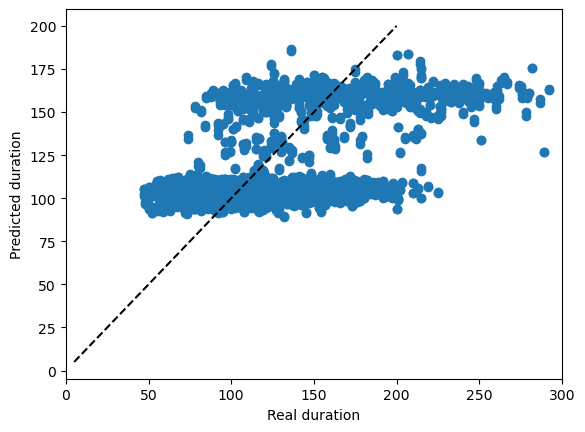

In [75]:
# Plot predicted duration without error bars 
# Most recent model

plt.scatter(ytest, ypred)
plt.plot([5, 200], [5, 200], 'k--')
plt.xlabel('Real duration')
plt.ylabel('Predicted duration')
plt.xlim((0, 300))
plt.show()

In [47]:
import time
import numpy as np

start_time = time.time()
importances = rf_regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_regr.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.061 seconds


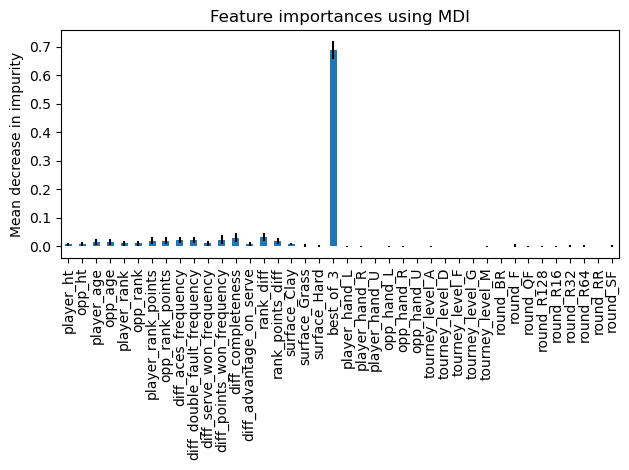

In [48]:
feature_names = list(Xtrain.columns)
# feature_names = [f"feature {i}" for i in range(Xtrain.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

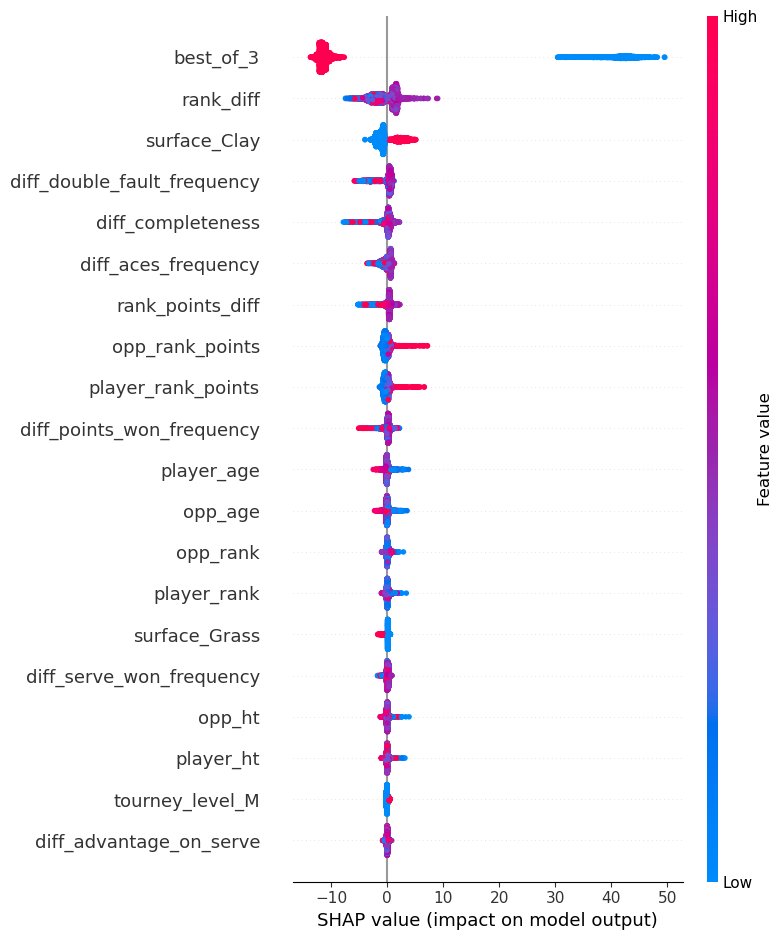

In [44]:
# Shap plot
import shap

explainer = shap.TreeExplainer(rf_regr)
shap_values = explainer.shap_values(Xtest)
shap.summary_plot(shap_values, Xtest)

In [20]:
def get_interval_score_rf(ypred, ytest, interval_size=20):
    ytest_bis = ytest.reshape(-1,)
    correct_pred = np.abs(ypred-ytest_bis) <= interval_size//2
    interval_score = np.count_nonzero(correct_pred)/len(correct_pred)
    return interval_score

In [21]:
minutes_error = []
correct_date_percentage = []
for i in range(10,40,10):
    
    print(f"plus ou moins {i} minutes: {round((get_interval_score_rf(ypred, ytest, interval_size=i*2)),3) *100}%")
    minutes_error.append(i)
    correct_date_percentage.append(round((get_interval_score_rf(ypred, ytest, interval_size=i*2)),3) *100)
    

plus ou moins 10 minutes: 20.0%
plus ou moins 20 minutes: 40.2%
plus ou moins 30 minutes: 58.9%


# Tentative de mise à jour de l'application de Bowen (utilisation du modèle sur une nouvelle input):

TypeError: unsupported operand type(s) for /: 'float' and 'builtin_function_or_method'

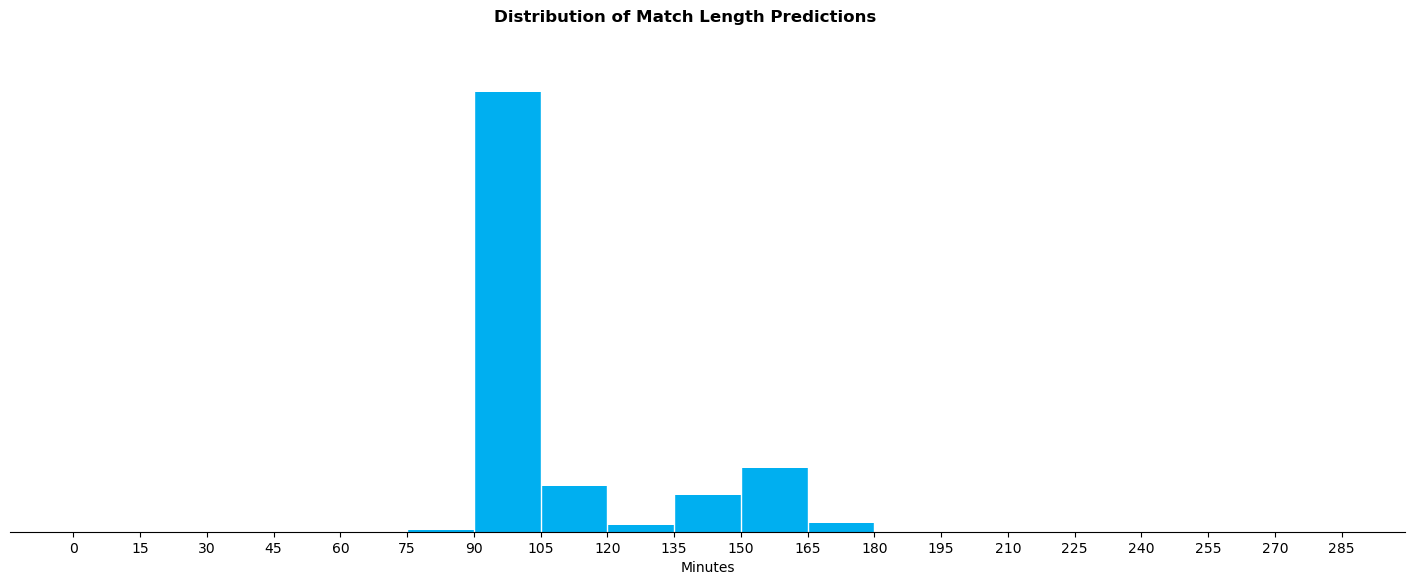

In [21]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0
# Rolland Garros Orange : #CB5A19
# Tennis Ball Yellow : #8CFF00

time_step = 15  # precision : 15/20/30 minutes

def plot_distribution(time_step) : 
    
    fig, ax = plt.subplots(1, figsize=(18,6))

    #plt.suptitle(f'Distribution of Match Length Predictions : {PLAYER1} v. {PLAYER2}', fontweight='bold')
    plt.suptitle(f'Distribution of Match Length Predictions', fontweight='bold')
    plt.xlabel("Minutes")
    # plt.ylabel("Nb of predictions")

    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yticks([])
    
    
    intervals=np.arange(0, 300, time_step)
    n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

    plt.xticks(bins)
    plt.grid(color='white', lw = 1, axis='x')

    xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]

    for idx, value in enumerate(n) :
        if value > 0 :
            plt.text(xticks[idx], value * 1.05, f"{int(100 * value / iter)}%", ha='center')
            plt.text(xticks[idx], value / 2, int(value), ha='center', color='w', fontweight='semibold')
        
    if (average_prediction >= 0) : plt.axvline(x=average_prediction, color='#CB5A19')
    # plt.axvline(x=116, color='#8CFF00')
    # plt.legend()


    plt.show()

plot_distribution(time_step)


In [ ]:
atp_all_players_columns = ['tourney_name', 'surface', 'tourney_level', 'tourney_date',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
       'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt',
       'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
       'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points',
       'loser_rank', 'loser_rank_points', 'diff_aces_frequency',
       'diff_double_fault_frequency', 'diff_serve_won_frequency',
       'diff_points_won_frequency', 'diff_completeness',
       'diff_advantage_on_serve', 'nb_common_opponents', 'Sipko_uncertainty',
       'Leo_uncertainty']

In [ ]:
# Solution rapide : Pour les attributs additionnels, récupérer les valeurs calculées pour ce couple de joueur pour le match le plus récent disputé entre eux deux
# Pour les autres attributs : ['tourney_name', 'surface', 'tourney_level', 'tourney_date',
#       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
#       'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age',
#       'score', 'best_of', 'round', 'minutes']  
# -> créer un dataframe à feed à "postprocessing()" puis appliquer les fonctions suivantes.

# Preprocessing test data
# atp_test = atp_all_players[atp_all_players['tourney_date'] >= min_test_tourney_date] # todo: delete this line
if validation_instead_of_test:
    atp_test = atp_test[atp_test['tourney_date'] <= max_tourney_date]
# Filling missing values with random existing data.
# We decided to avoid using mean values in order to reduce the bias induced by the chosen filling method.
atp_test.sample(frac=1, random_state=42)
atp_test = atp_test.fillna(method="ffill")
atp_test = atp_test.fillna(method="bfill")

columns_used_by_model = ['minutes'] + list(Xtrain.columns)       
Xtest, ytest = preprocess_atp(atp_test, is_atp_raw=True, train_df_columns=columns_used_by_model)

# + cf le code "INTERFACE" ci-dessous
# creation du dataframe pour l'inférence:
# ht = float(player2_height_display.value)
# a = float(player2_age_display.value)
# rk = float(player1_rank_display.value) - float(player2_rank_display.value)
# c = int(player1_cons_display.value)
# s = t2i(sd, surface_radio.value)
# bo = int(t2i(bod, best_of_radio.value))
# h = t2i(hd, player2_hand_display.value)
# l = t2i(ld, level_dropdown.value)
# r = t2i(rd, round_dropdown.value)

# custom_predict(dtr, scale_x, scale_y, ht, a, rk, c, s, bo, h, l, r)
# def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round)


In [ ]:
### INTERFACE ###

# Validate Button

button = widgets.Button(description="Confirm")
out1 = widgets.Output()
display(button, out1)


# Match Settings

match_settings_title = widgets.Label(value='MATCH CONDITIONS')

surface_radio = widgets.RadioButtons(
    options=['Hard', 'Grass', 'Clay'],
    description='Surface',
    disabled=False
)

best_of_radio = widgets.RadioButtons(
    options=['3', '5'],
    description='Best of',
    disabled=False
)

level_dropdown = widgets.Dropdown(
    description="Level",
    options=['Grand Slam (G)', 'Masters 1000s (M)', 'Other (A)']
)

round_dropdown = widgets.Dropdown(
    description="Round",
    options=['Final', 'Semifinals', 'Quarterfinals', 'R16', 'R32', 'R64', 'R128', 'R']
)

match_inputs_1 = widgets.HBox([surface_radio, best_of_radio])
match_inputs_2 = widgets.HBox([level_dropdown, round_dropdown])

# Players

player1_title = widgets.Label(value='PLAYER 1')

player1_text = widgets.Text(value=PLAYER1, placeholder="Player 1", description='Name')

player1_height_display = widgets.Text(description='Height')
player1_hand_display = widgets.Text(description='Hand')
player1_rank_display = widgets.Text(description='Rank')
player1_age_display = widgets.Text(description='Age')
player1_cons_display = widgets.Text(description='Win streak')

if (pd.notna(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])) :
    player1_height_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])
else :
    player1_height_display.value = '185'
player1_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0])
player1_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0])
player1_age_display.value = '25'
player1_cons_display.value = '0'

player1_widgets = widgets.VBox([player1_title, player1_text, player1_height_display, player1_hand_display, player1_rank_display, player1_age_display, player1_cons_display])


player2_title = widgets.Label(value='PLAYER 2')

player2_text = widgets.Text(value=PLAYER2, placeholder="Player 2", description='Name')

player2_height_display = widgets.Text(description='Height')
player2_hand_display = widgets.Text(description='Hand')
player2_rank_display = widgets.Text(description='Rank')
player2_age_display = widgets.Text(description='Age')
player2_cons_display = widgets.Text(description='Win streak')

if (pd.notna(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])) :
    player2_height_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])
else :
    player2_height_display.value = '185'
player2_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0])
player2_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0])
player2_age_display.value = '25'
player2_cons_display.value = '0'

player2_widgets = widgets.VBox([player2_title, player2_text, player2_height_display, player2_hand_display, player2_rank_display, player2_age_display, player2_cons_display])


player_inputs = widgets.HBox([player1_widgets, player2_widgets])

display(match_settings_title, match_inputs_1, match_inputs_2)
display(player_inputs)
print("(Optional) For better precision, input player age and win streak.")



### BEHAVIOR ###

def validate(b):
    global PLAYER1
    global PLAYER2
    out1.clear_output()
    if (def_player1_text.value in atp_players.name.values) and (def_player2_text.value in atp_players.name.values) :
        with out1 :
            print("Valid players.")
        PLAYER1 = def_player1_text.value
        player1_text.value = PLAYER1
        PLAYER2 = def_player2_text.value
        player2_text.value = PLAYER2
    else :
        with out1 :
            print("Invalid players. Try again.")

button.on_click(validate)

def player1_eventhandler(change):
    global PLAYER1
    if change.new in atp_players.name.values :
        PLAYER1 = change.new
        if (pd.notna(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])) :
            player1_height_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0])
        else :
            player1_height_display.value = '185'
        player1_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0])
        player1_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0])
        
def player2_eventhandler(change):
    global PLAYER2
    if change.new in atp_players.name.values :
        PLAYER2 = change.new
        if (pd.notna(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])) :
            player2_height_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0])
        else :
            player2_height_display.value = '185'
        player2_hand_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0])
        player2_rank_display.value = str(atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0])

player1_text.observe(player1_eventhandler, names='value')
player2_text.observe(player2_eventhandler, names='value')

Button(description='Confirm', style=ButtonStyle())

Output()

Label(value='MATCH CONDITIONS')

(Optional) For better precision, input player age and win streak.


In [ ]:
### REGRESSION FOREST UI ###
# UI

launch_btn = widgets.Button(description='Plant Forest')
out2 = widgets.Output()
display(launch_btn)
display(out2)

Button(description='Plant Forest', style=ButtonStyle())

Output()

Drag slider to plot :


IntSlider(value=15, description='Time Step', max=45, min=5, step=5)

Output()

Best parameters: {'max_depth': 4, 'min_samples_leaf': 62})
Training score 1 :  0.34822352710043436
Testing score 1 :  0.33216706935806994
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [104.37755102]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 4, 'min_samples_leaf': 71})
Training score 2 :  0.3350885794447769
Testing score 2 :  0.3490607259431744
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [106.27956989]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 5, 'min_samples_leaf': 58})
Training score 3 :  0.3717809413316939
Testing score 3 :  0.23665041332021464
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [98.5483871]  minutes
------------------------------------------------------------------------------------------------
Best parameters: {'max_depth': 5, 'min_samples_leaf': 25})
Training score 4 :  0.3943651602434781
Testing score 4 :  0.30396023762961455
[185.0, 25.0, 12.0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185.0,25.0,12.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prediction :  [84.41176471]  minutes
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Test scores :  [0.33216706935806994, 0.3490607259431744, 0.23665041332021464, 0.30396023762961455]
Test scores average :  0.30545961156276835
------------------------------------------------------------------------------------------------
Predictions : [104.37755102040816, 106.27956989247312, 98.54838709677419, 84.41176470588235]
Average predicted length : 98.40431817888447


In [ ]:
reset_btn = widgets.Button(description="Reset")

def reset_click(change):
    global test_scores
    global predictions
    global average_prediction
    test_scores = []
    predictions = []
    average_prediction = -1
    
    out1.clear_output()
    out2.clear_output()
    out3.clear_output()
    
    
reset_btn.on_click(reset_click)

display(reset_btn)

Button(description='Reset', style=ButtonStyle())

In [22]:
!pip freeze > requirements.txt

# Manually registered data used to plot some of the curves

In [ ]:
# manually registered scores using shallow forest(max_depth=10), 250 lambdas for hist data calc and for data weights.

validation_score_list_1 = [0.25276636144490494,
 0.25566477657275166,
 0.2550791897832626,
 0.260831294987962,
 0.2635623301812321,
 0.26490603177014516,
 0.26821741898014406,
 0.2758502483971641,
 0.2794366318180146,
 0.28204030357001353,
 0.2779234034827429,
 0.2792492829800278]
uncertainty_treshold_list_1 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1. ]

# validation_score_list_1 = [0.2635623301812321,
#  0.26490603177014516,
#  0.26821741898014406,
#  0.2758502483971641,
#  0.2794366318180146,
#  0.28204030357001353,
#  0.2779234034827429]
# uncertainty_treshold_list_1 = [0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]


# Shallow forest(max_depth=7), 250 lambdas for hist data calc and for data weights.

validation_score_list_2 = [0.2563858271467391,
 0.2610308226250946,
 0.2602652349242137,
 0.25591660650111225,
 0.2590588583048079,
 0.25683556186147705,
 0.26425697152114624,
 0.2689918260329567,
 0.2663862556993709,
 0.2683437634121296,
 0.2717239793017725,
 0.27692084967637687,
 0.28173347687192896,
 0.2833756976725448,
 0.2790590544410605,
 0.2817865943624204,
 0.2817865943624204]
uncertainty_treshold_list_2 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

# # shallow forest (max_depth=10), 730 lambda for hist data calc and 250 for data weights
# validation_score_list_3 = [0.23316879510486266,
#  0.23796345006963115,
#  0.24943471432848396,
#  0.2495598149448246,
#  0.2507817850926629,
#  0.2500930750970253,
#  0.2514304976082602,
#  0.2551244855705863,
#  0.2657094962192209,
#  0.263596913892709,
#  0.2651691553189258,
#  0.2618682158676018,
#  0.27310549099012915,
#  0.2761039092807548,
#  0.2734404157171143,
#  0.27452365133296786,
#  0.27452365133296786]
# uncertainty_treshold_list_3 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
#        0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

# shallow forest (max_depth=7), 730 lambda for hist data calc and 250 for data weights
validation_score_list_4 = [0.23743077928177503,
 0.241010202406445,
 0.25290357060935886,
 0.25257798709532187,
 0.25482778500961545,
 0.2530572089998826,
 0.2559122672127506,
 0.2578373890017789,
 0.2693582016987611,
 0.2664727927229694,
 0.26945339244863453,
 0.2665159338484,
 0.27757446941996233,
 0.2800211350738052,
 0.27669838724336104,
 0.27759621193200656,
 0.27759621193200656]
uncertainty_treshold_list_4 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.]



# deep forest, 730 lambda for hist data calc and for data weights
validation_score_list_5 = [0.2614789130458399,
 0.2681838707015396,
 0.27316175209917826,
 0.2683317827350624,
 0.26844588956858084,
 0.2669555788683773,
 0.2673651087527391,
 0.2689317459641961,
 0.27431285427487373,
 0.2728494677107307,
 0.2751036706574448,
 0.2733808717768247,
 0.27698445358373525,
 0.2765075818436713,
 0.2746664950342499,
 0.2756650226925923,
 0.2756650226925923]
uncertainty_treshold_list_5 = [0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]

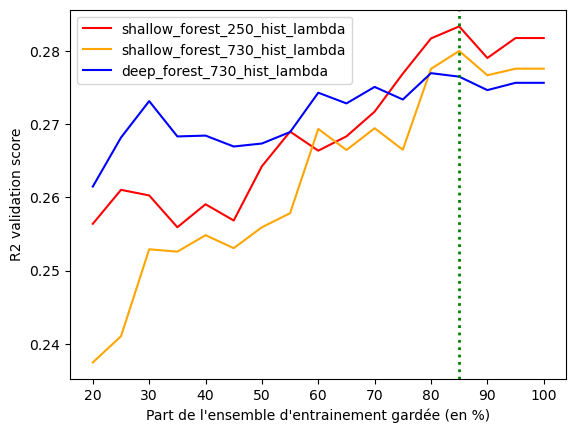

In [ ]:
plt.xlabel("Part de l'ensemble d'entrainement gardée (en %)")
# Set the y axis label of the current axis.
plt.ylabel('R2 validation score')
# Set a title 
# Display the figure.
plt.plot(np.round_(np.array(uncertainty_treshold_list_2)*100,  decimals = 0),validation_score_list_2, color='red',  label = 'shallow_forest_250_hist_lambda')
plt.plot(np.round_(np.array(uncertainty_treshold_list_4)*100,  decimals = 0),validation_score_list_4, color='orange',  label = 'shallow_forest_730_hist_lambda')
plt.plot(np.round_(np.array(uncertainty_treshold_list_5)*100,  decimals = 0),validation_score_list_5, color='blue',  label = 'deep_forest_730_hist_lambda')


plt.axvline(x=85, color='green', ls=':', lw=2)
#plt.axvline(x=730, color='green', ls=':', lw=2)
# show a legend on the plot
plt.legend()
plt.show()